In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/rodrigo-dataset-spanish/README.txt
/kaggle/input/rodrigo-dataset-spanish/Rodrigo corpus 1.0.0/partitions/test.txt
/kaggle/input/rodrigo-dataset-spanish/Rodrigo corpus 1.0.0/partitions/validation.txt
/kaggle/input/rodrigo-dataset-spanish/Rodrigo corpus 1.0.0/partitions/train.txt
/kaggle/input/rodrigo-dataset-spanish/Rodrigo corpus 1.0.0/images/Rodrigo_00073_14.png
/kaggle/input/rodrigo-dataset-spanish/Rodrigo corpus 1.0.0/images/Rodrigo_00564_04.png
/kaggle/input/rodrigo-dataset-spanish/Rodrigo corpus 1.0.0/images/Rodrigo_00520_00.png
/kaggle/input/rodrigo-dataset-spanish/Rodrigo corpus 1.0.0/images/Rodrigo_00560_13.png
/kaggle/input/rodrigo-dataset-spanish/Rodrigo corpus 1.0.0/images/Rodrigo_00023_15.png
/kaggle/input/rodrigo-dataset-spanish/Rodrigo corpus 1.0.0/images/Rodrigo_00495_17.png
/kaggle/input/rodrigo-dataset-spanish/Rodrigo corpus 1.0.0/images/Rodrigo_00192_04.png
/kaggle/input/rodrigo-dataset-spanish/Rodrigo corpus 1.0.0/images/Rodrigo_00199_15.png
/kaggle/inp

In [ ]:
from sklearn.model_selection import train_test_split

train_data, val_data = train_test_split(data, test_size=0.2,train_size=0.05, random_state=42)

In [ ]:
from transformers import TrOCRProcessor, VisionEncoderDecoderModel

processor = TrOCRProcessor.from_pretrained("qantev/trocr-base-spanish")
model = VisionEncoderDecoderModel.from_pretrained("qantev/trocr-base-spanish")

In [ ]:
import evaluate
cer_metric = evaluate.load("cer")

def compute_metrics(pred):
    labels_ids = pred.label_ids
    pred_ids = pred.predictions
    pred_str = processor.batch_decode(pred_ids, skip_special_tokens=True)
    labels_str = processor.batch_decode(labels_ids, skip_special_tokens=True)
    cer = cer_metric.compute(predictions=pred_str, references=labels_str)
    return {"cer": cer}

In [ ]:
trainer = Seq2SeqTrainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics
)

In [ ]:
model.save_pretrained("trocr-rodrigo")
processor.save_pretrained("trocr-rodrigo")

In [ ]:
from PIL import Image

image = Image.open("new_image.png").convert("RGB")
pixel_values = processor(image, return_tensors="pt").pixel_values
generated_ids = model.generate(pixel_values)
text = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]
print(text)

In [ ]:
!pip install evaluate

In [ ]:
import os
import pandas as pd
from PIL import Image
from sklearn.model_selection import train_test_split
from transformers import (
    TrOCRProcessor,
    VisionEncoderDecoderModel,
    Seq2SeqTrainingArguments,
    Seq2SeqTrainer,
    default_data_collator
)
import torch
from torch.utils.data import Dataset
import evaluate
import numpy as np
from torchvision.transforms import (
    RandomAdjustSharpness,
    RandomRotation,
    ColorJitter,
    Compose
)

In [ ]:
# Configuration
BASE_PATH = "/kaggle/input/"
MODEL_NAME = "qantev/trocr-large-spanish"
CACHE_DIR = "./dataset_cache"
BATCH_SIZE = 2  # Reduce if OOM occurs
MAX_TEXT_LENGTH = 128  # Adjust based on your text length distribution

In [ ]:
# --------------------------------------------------
# 1. Optimized Dataset Preparation
# --------------------------------------------------
import os
import torch

In [ ]:
BASE_PATH = "/kaggle/input/"  # Confirm this is correct!
CACHE_DIR = "./dataset_cache"

def load_and_preprocess_data():
    """Robust parser for your specific format"""
    txt_path = os.path.join(BASE_PATH, "rodrigo-spanish-text-17th-century/text/transcriptions.txt")
    
    data = []
    with open(txt_path, "r", encoding="utf-8", errors="replace") as f:
        for line_idx, line in enumerate(f):
            line = line.strip()
            if not line:
                continue
                
            # Split on first space only
            try:
                img_id, text = line.split(" ", 1)
            except ValueError:
                print(f"Skipping malformed line {line_idx+1}: {line[:50]}...")
                continue
                
            # Construct EXACT image path (case-sensitive!)
            img_file = f"{img_id}.png"
            img_path = os.path.join(BASE_PATH, "rodrigo-spanish-text-17th-century/images", img_file)
            
            # Verify existence with case sensitivity
            if os.path.isfile(img_path):
                data.append((img_path, text))
            else:
                print(f"Missing image: {img_file}")
                
    return data

# Load data with verification
data = load_and_preprocess_data()

# Manual verification for first 5 entries
print("\nFirst 5 valid entries:")
for path, text in data[:5]:
    print(f"Image: {os.path.basename(path)}")
    print(f"Text: {text}\n")
    assert os.path.exists(path), f"Path {path} does not exist!"
    
print(f"Total valid samples: {len(data)}")

Loaded 15010 valid samples


<ipython-input-6-edf1571edf90>:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(CACHE_DIR)
Config of the encoder: <class 'transformers.models.vit.modeling_

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Starting training...


/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


In [23]:
rm -rf ./dataset_cache

In [5]:
!pip install jiwer

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.2/98.2 kB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 60.1 MB/s eta 0:00:00:00:01
  Attempting uninstall: click
    Found existing installation: click 8.1.7
    Uninstalling click-8.1.7:
      Successfully uninstalled click-8.1.7


In [4]:
from torch.utils.data import Dataset, DataLoader

# Full corrected import section
import os
import torch
from PIL import Image
from sklearn.model_selection import train_test_split
from transformers import (
    TrOCRProcessor,
    VisionEncoderDecoderModel,
    Seq2SeqTrainingArguments,
    Seq2SeqTrainer,
    default_data_collator
)
import gc
import psutil
from torch.utils.data import Dataset  # <-- THIS WAS MISSING

# ====================== ULTRA-LOW-MEMORY CONFIG ======================
BASE_PATH = "/kaggle/input/"
MODEL_NAME = "qantev/trocr-large-spanish"
BATCH_SIZE = 4                    # Minimum possible batch size
MAX_TEXT_LENGTH = 128             # Reduced from 128
SUBSET_FRACTION = 1.0           # Use only 5% of data
DISABLE_AUGMENTATION = True        # Reduce CPU overhead
NUM_WORKERS = 0                    # Critical for Kaggle stability
# =====================================================================

def print_memory_usage():
    """Debug tool for memory issues"""
    process = psutil.Process(os.getpid())
    print(f"Memory usage: {process.memory_info().rss / 1024 ** 2:.2f} MB")

# --------------------------------------------------
# 1. Streamlined Dataset Class (Critical Fixes)
# --------------------------------------------------
class RodrigoDataset(Dataset):
    def __init__(self, data, processor):
        self.data = data
        self.processor = processor
        self._preload_images()  # Trade disk I/O for predictable memory
        
    def _preload_images(self):
        """Preprocess all images upfront for memory stability"""
        self.processed_samples = []
        for img_path, text in self.data:
            try:
                with Image.open(img_path) as img:
                    pixel_values = self.processor(
                        img.convert("RGB"), 
                        return_tensors="pt"
                    ).pixel_values.squeeze()
                    
                    labels = self.processor.tokenizer(
                        text,
                        padding="max_length",
                        max_length=MAX_TEXT_LENGTH,
                        truncation=True
                    ).input_ids
                    
                    self.processed_samples.append({
                        "pixel_values": pixel_values,
                        "labels": torch.tensor(labels)
                    })
            except Exception as e:
                print(f"Skipped {img_path}: {str(e)}")
                
        print(f"Successfully loaded {len(self.processed_samples)}/{len(self.data)} samples")

    def __len__(self):
        return len(self.processed_samples)

    def __getitem__(self, idx):
        """Direct access to preprocessed data"""
        return self.processed_samples[idx]

# --------------------------------------------------
# 2. Memory-Optimized Data Loading
# --------------------------------------------------
def load_and_preprocess_data():
    """Robust parser for your specific format"""
    txt_path = os.path.join(BASE_PATH, "rodrigo-dataset-spanish/Rodrigo corpus 1.0.0/text/transcriptions.txt")
    
    data = []
    with open(txt_path, "r", encoding="utf-8", errors="replace") as f:
        for line_idx, line in enumerate(f):
            line = line.strip()
            if not line:
                continue
                
            # Split on first space only
            try:
                img_id, text = line.split(" ", 1)
            except ValueError:
                print(f"Skipping malformed line {line_idx+1}: {line[:50]}...")
                continue
                
            # Construct EXACT image path (case-sensitive!)
            img_file = f"{img_id}.png"
            img_path = os.path.join(BASE_PATH, "rodrigo-dataset-spanish/Rodrigo corpus 1.0.0/images", img_file)
            
            # Verify existence with case sensitivity
            if os.path.isfile(img_path):
                data.append((img_path, text))
            else:
                print(f"Missing image: {img_file}")
                
    return data

# Load data with verification
#data = load_and_preprocess_data()
print("Loading data...")


# --------------------------------------------------
# 3. CPU-Specific Training Configuration
# --------------------------------------------------
training_args = Seq2SeqTrainingArguments(
    output_dir="./output",
    per_device_train_batch_size=BATCH_SIZE,
    per_device_eval_batch_size=4,
    gradient_accumulation_steps=8,         # Compensate tiny batch size
    learning_rate=3e-5,
    num_train_epochs=3,
    logging_steps=10,
    evaluation_strategy="no",              # Disable validation during training
    save_strategy="no",                    # Disable checkpointing
    report_to="none",
    dataloader_num_workers=NUM_WORKERS,
    group_by_length=False,
    fp16=True,                            # Disable for CPU
    optim="adafactor",                     # Memory-efficient optimizer
)

# --------------------------------------------------
# 4. Memory-Critical Training Execution
# --------------------------------------------------
# 4. Memory-Critical Training Execution (FIXED)
# --------------------------------------------------
def safe_train():
    global raw_data
    
    # Initialize components
    processor = TrOCRProcessor.from_pretrained(MODEL_NAME)
    model = VisionEncoderDecoderModel.from_pretrained(MODEL_NAME)
    
    # Create datasets
    train_data, _ = train_test_split(raw_data, test_size=0.2)
    train_dataset = RodrigoDataset(train_data, processor)
    
    # Initialize Trainer
    trainer = Seq2SeqTrainer(  # THIS WAS MISSING
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        data_collator=default_data_collator,
    )
    
    # ACTUAL TRAINING EXECUTION  # THIS WAS MISSING
    trainer.train() 
    trainer.save_model()  # Final model save
    processor.save_pretrained(training_args.output_dir)
    
    # Verify model files
    print(f"Model saved to: {training_args.output_dir}")
    print(os.listdir(training_args.output_dir))
    
    # Free memory
    del raw_data, train_data, model, processor
    gc.collect()

full_data = load_and_preprocess_data()  # First load complete data
subset_size = int(len(full_data) * SUBSET_FRACTION)
raw_data = full_data[:subset_size]      # Then take subset
del full_data                           # Free memory immediately
print_memory_usage()

Loading data...


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Memory usage: 1106.79 MB


In [ ]:
if __name__ == "__main__":
    safe_train()
    print("Training completed successfully!")

Loading data...


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Memory usage: 1111.98 MB


preprocessor_config.json:   0%|          | 0.00/364 [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/957 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

pytorch_model.bin:   0%|          | 0.00/2.44G [00:00<?, ?B/s]

Config of the encoder: <class 'transformers.models.vit.modeling_vit.ViTModel'> is overwritten by shared encoder config: ViTConfig {
  "attention_probs_dropout_prob": 0.0,
  "encoder_stride": 16,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.0,
  "hidden_size": 1024,
  "image_size": 384,
  "initializer_range": 0.02,
  "intermediate_size": 4096,
  "layer_norm_eps": 1e-12,
  "model_type": "vit",
  "num_attention_heads": 16,
  "num_channels": 3,
  "num_hidden_layers": 24,
  "patch_size": 16,
  "qkv_bias": false,
  "transformers_version": "4.47.0"
}

Config of the decoder: <class 'transformers.models.trocr.modeling_trocr.TrOCRForCausalLM'> is overwritten by shared decoder config: TrOCRConfig {
  "activation_dropout": 0.0,
  "activation_function": "relu",
  "add_cross_attention": true,
  "attention_dropout": 0.0,
  "bos_token_id": 0,
  "classifier_dropout": 0.0,
  "d_model": 1024,
  "decoder_attention_heads": 16,
  "decoder_ffn_dim": 4096,
  "decoder_layerdrop": 0.0,
  "decoder_layers":

generation_config.json:   0%|          | 0.00/420 [00:00<?, ?B/s]

Successfully loaded 12008/12008 samples


/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Step,Training Loss
10,24.093200
20,1.724500
30,0.985300
40,0.803300
50,0.683600
60,0.592400
70,0.522300
80,0.541000
90,0.479100
100,0.444800


/usr/local/lib/python3.10/dist-packages/transformers/modeling_utils.py:2817: UserWarning: Moving the following attributes in the config to the generation config: {'no_repeat_ngram_size': 3}. You are seeing this warning because you've set generation parameters in the model config, as opposed to in the generation config.
  warnings.warn(


Model saved to: ./output
['tokenizer_config.json', 'generation_config.json', 'vocab.json', 'preprocessor_config.json', 'training_args.bin', 'special_tokens_map.json', 'model.safetensors', 'tokenizer.json', 'config.json', 'merges.txt']
Training completed successfully!


In [5]:
# During initial data loading
full_data = load_and_preprocess_data()

# Split into THREE parts: train, val, test
train_val_data, test_data = train_test_split(full_data, test_size=0.1, random_state=42)  # 10% for testing
train_data, val_data = train_test_split(train_val_data, test_size=0.2, random_state=42)  # 20% of remaining for val

# Apply subset only to training data
train_subset = train_data[:int(len(train_data) * SUBSET_FRACTION)]

In [6]:
import random

Config of the encoder: <class 'transformers.models.vit.modeling_vit.ViTModel'> is overwritten by shared encoder config: ViTConfig {
  "attention_probs_dropout_prob": 0.0,
  "encoder_stride": 16,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.0,
  "hidden_size": 1024,
  "image_size": 384,
  "initializer_range": 0.02,
  "intermediate_size": 4096,
  "layer_norm_eps": 1e-12,
  "model_type": "vit",
  "num_attention_heads": 16,
  "num_channels": 3,
  "num_hidden_layers": 24,
  "patch_size": 16,
  "qkv_bias": false,
  "transformers_version": "4.47.0"
}

Config of the decoder: <class 'transformers.models.trocr.modeling_trocr.TrOCRForCausalLM'> is overwritten by shared decoder config: TrOCRConfig {
  "activation_dropout": 0.0,
  "activation_function": "relu",
  "add_cross_attention": true,
  "attention_dropout": 0.0,
  "bos_token_id": 0,
  "classifier_dropout": 0.0,
  "d_model": 1024,
  "decoder_attention_heads": 16,
  "decoder_ffn_dim": 4096,
  "decoder_layerdrop": 0.0,
  "decoder_layers":

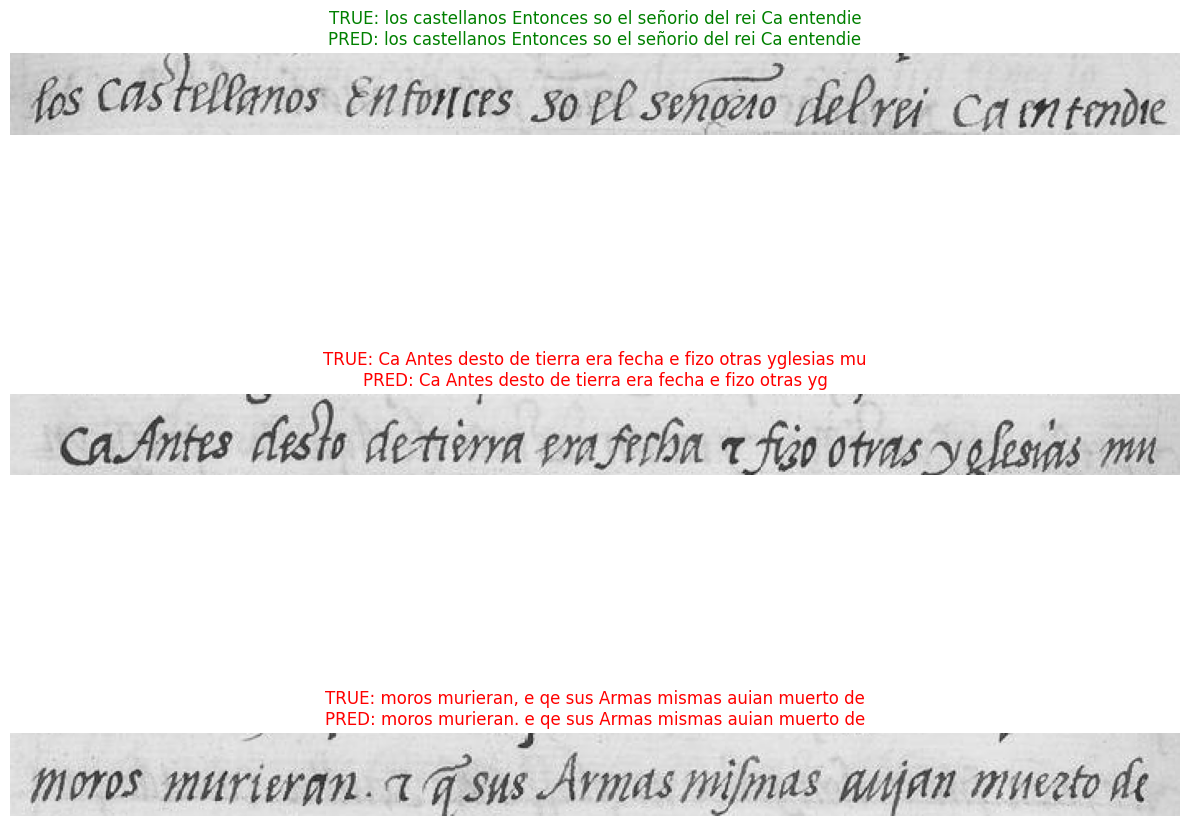

In [7]:
def test_model_on_unseen_data(model_path, test_samples=3):
    # Load from true test set
    processor = TrOCRProcessor.from_pretrained(model_path)
    model = VisionEncoderDecoderModel.from_pretrained(model_path)
    model.eval()
    
    # Random test samples
    samples = random.sample(test_data, test_samples)
    
    # Visualization and prediction
    fig, axes = plt.subplots(test_samples, 1, figsize=(12, 4*test_samples))
    
    for idx, (img_path, true_text) in enumerate(samples):
        image = Image.open(img_path).convert("RGB")
        pixel_values = processor(image, return_tensors="pt").pixel_values
        
        with torch.no_grad():
            generated_ids = model.generate(pixel_values)
            pred_text = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]
        
        axes[idx].imshow(image)
        axes[idx].axis('off')
        color = 'green' if pred_text == true_text else 'red'
        axes[idx].set_title(f"TRUE: {true_text}\nPRED: {pred_text}", color=color)
    
    plt.tight_layout()
    plt.show()

# Usage AFTER training
test_model_on_unseen_data("./output", 3)

Config of the encoder: <class 'transformers.models.vit.modeling_vit.ViTModel'> is overwritten by shared encoder config: ViTConfig {
  "attention_probs_dropout_prob": 0.0,
  "encoder_stride": 16,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.0,
  "hidden_size": 1024,
  "image_size": 384,
  "initializer_range": 0.02,
  "intermediate_size": 4096,
  "layer_norm_eps": 1e-12,
  "model_type": "vit",
  "num_attention_heads": 16,
  "num_channels": 3,
  "num_hidden_layers": 24,
  "patch_size": 16,
  "qkv_bias": false,
  "transformers_version": "4.47.0"
}

Config of the decoder: <class 'transformers.models.trocr.modeling_trocr.TrOCRForCausalLM'> is overwritten by shared decoder config: TrOCRConfig {
  "activation_dropout": 0.0,
  "activation_function": "relu",
  "add_cross_attention": true,
  "attention_dropout": 0.0,
  "bos_token_id": 0,
  "classifier_dropout": 0.0,
  "d_model": 1024,
  "decoder_attention_heads": 16,
  "decoder_ffn_dim": 4096,
  "decoder_layerdrop": 0.0,
  "decoder_layers":

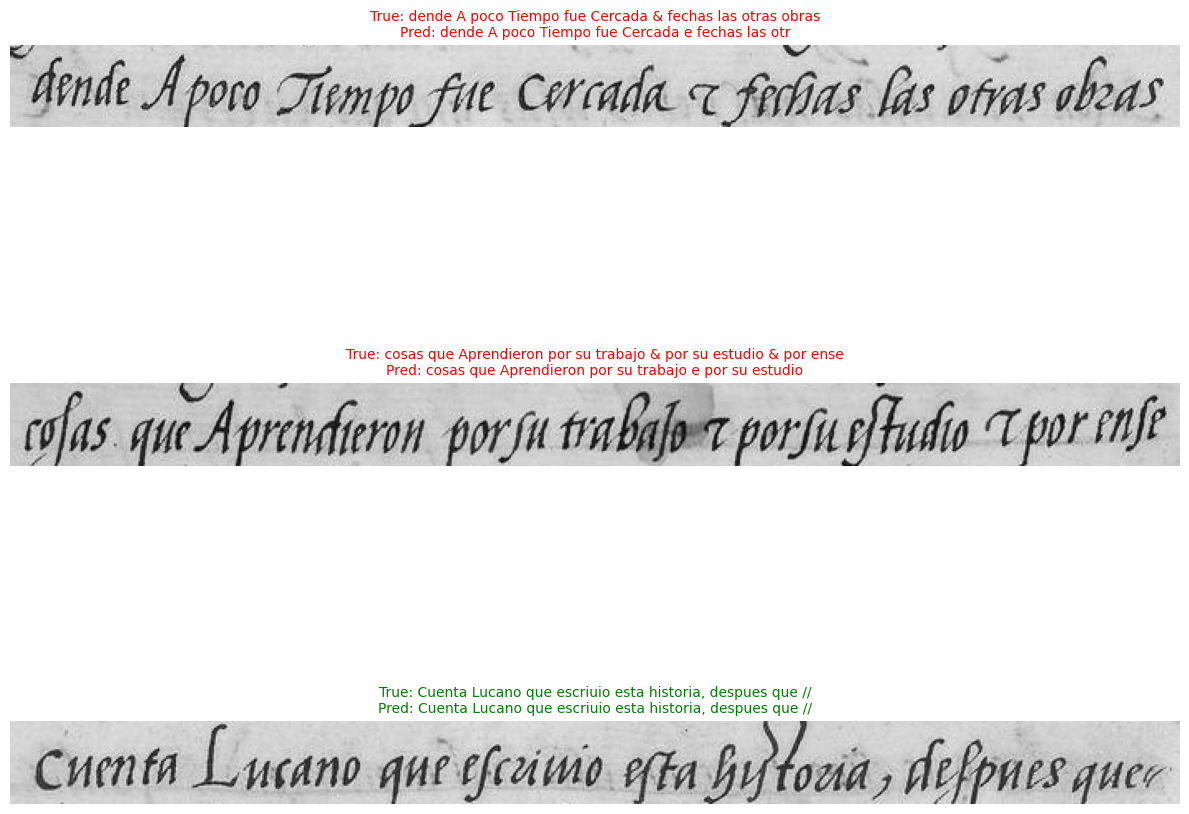

In [8]:
import random
import matplotlib.pyplot as plt
def test_model_on_samples(model_path, num_samples=3):
    # 1. Load fresh test data
    test_data = load_and_preprocess_data()  # Reload from source
    test_data = test_data[:int(len(test_data) * 0.1)]  # 10% for testing
    
    # 2. Load model components
    processor = TrOCRProcessor.from_pretrained(model_path)
    model = VisionEncoderDecoderModel.from_pretrained(model_path)
    model.eval()
    
    # 3. Select random samples
    test_samples = random.sample(test_data, num_samples)
    
    # 4. Configure plot
    fig, axes = plt.subplots(num_samples, 1, figsize=(12, 4*num_samples))
    
    for idx, (img_path, true_text) in enumerate(test_samples):
        try:
            # Load and process image
            image = Image.open(img_path).convert("RGB")
            pixel_values = processor(image, return_tensors="pt").pixel_values
            
            # Generate prediction
            with torch.no_grad():
                generated_ids = model.generate(pixel_values)
                generated_text = processor.batch_decode(generated_ids, 
                                                      skip_special_tokens=True)[0]
            
            # Display results
            axes[idx].imshow(image)
            axes[idx].axis('off')
            title_color = 'green' if generated_text == true_text else 'red'
            axes[idx].set_title(f"True: {true_text}\nPred: {generated_text}", 
                              color=title_color, fontsize=10)
            
        except Exception as e:
            print(f"Error processing {img_path}: {str(e)}")
            continue
    
    plt.tight_layout()
    plt.show()

# Usage: Test on 3 samples from FRESH data
test_model_on_samples("./output", 3)